Comando para entrenar el modelo

In [ ]:
#Train model with
#Bash Command
"""yolo detect train \
  data=/home/higgsos/Escritorio/agentes/Basil_yolo_data/data.yaml \
  model=yolov8n.pt \
  epochs=60 \
  imgsz=416 \
  batch=10 \
  device=cpu"""


Para reorganizar el dataset solo se ejecuta 1 vez

In [28]:
import shutil
import random
from pathlib import Path

# === RUTAS ===
base_dir = Path("/home/higgsos/Escritorio/agentes/YOLO")  # <- donde están las carpetas good/ y bad/
output_dir = base_dir / "YOLO_Dataset"
split_ratio = 0.8

# Crear estructura final
for split in ["train", "val"]:
    for sub in ["images", "labels"]:
        (output_dir / split / sub).mkdir(parents=True, exist_ok=True)

# Obtener imágenes de ambas clases
all_images = list((base_dir / "good").glob("*.jpg")) + list((base_dir / "bad").glob("*.jpg"))
random.shuffle(all_images)

# Dividir dataset
split_idx = int(len(all_images) * split_ratio)
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

# Función para copiar imagen y su label
def move_pair(img_path, split):
    label_name = img_path.stem + ".txt"
    label_path = base_dir / label_name

    if not label_path.exists():
        print(f"No se encontró etiqueta para {img_path.name}")
        return

    # Copiar imagen
    shutil.copy(img_path, output_dir / split / "images" / img_path.name)
    # Copiar etiqueta
    shutil.copy(label_path, output_dir / split / "labels" / label_name)

# Procesar imágenes
for img in train_images:
    move_pair(img, "train")

for img in val_images:
    move_pair(img, "val")

print("Dataset reorganizado exitosamente en formato YOLO.")


Dataset reorganizado exitosamente en formato YOLO.


para crear el archivo Yalm

In [29]:
from pathlib import Path

# Ruta base donde quedó tu dataset organizado
dataset_base = Path("/home/higgsos/Escritorio/agentes/YOLO/YOLO_Dataset").resolve()

# Contenido del archivo YAML
yaml_content = f"""
train: {dataset_base}/train/images
val: {dataset_base}/val/images

nc: 2
names: ['good', 'bad']
"""

# Guardar el archivo
yaml_path = dataset_base / "data.yaml"
yaml_path.write_text(yaml_content.strip())

print(f"Archivo 'data.yaml' creado en:\n{yaml_path}")


Archivo 'data.yaml' creado en:
/home/higgsos/Escritorio/agentes/YOLO/YOLO_Dataset/data.yaml


Remplazar marcas de los .txt

In [ ]:
from pathlib import Path

labels_dir = Path("/home/higgsos/Escritorio/agentes/YOLO")
replaced_files = 0

# Mapeo de clases incorrectas → correctas
class_map = {
    "15": "0",
    "16": "1"
}

for txt_file in labels_dir.glob("*.txt"):
    with open(txt_file, "r") as f:
        lines = f.readlines()

    new_lines = []
    modified = False

    for line in lines:
        parts = line.strip().split()
        if not parts or parts[0] not in class_map:
            new_lines.append(line.strip())  # conservar la línea si no necesita cambio
            continue

        # Reemplazar la clase
        original = parts[0]
        parts[0] = class_map[original]
        modified = True
        new_lines.append(" ".join(parts))

    if modified:
        replaced_files += 1
        with open(txt_file, "w") as f:
            f.write("\n".join(new_lines) + "\n")
        print(f"Corregido: {txt_file.name}")

print(f"\n Total de archivos corregidos: {replaced_files}")



🔧 Total de archivos corregidos: 0


Modelo de yolo


image 1/1 /home/higgsos/.cache/kagglehub/datasets/csafrit2/plant-leaves-for-image-classification/versions/2/Plants_2/test/Bael diseased (P4b)/0016_0007.JPG: 288x416 3 Unhealthys, 123.8ms
Speed: 5.1ms preprocess, 123.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)
Detecciones:
Clase: Unhealthy | Confianza: 0.80
Clase: Unhealthy | Confianza: 0.71
Clase: Unhealthy | Confianza: 0.66


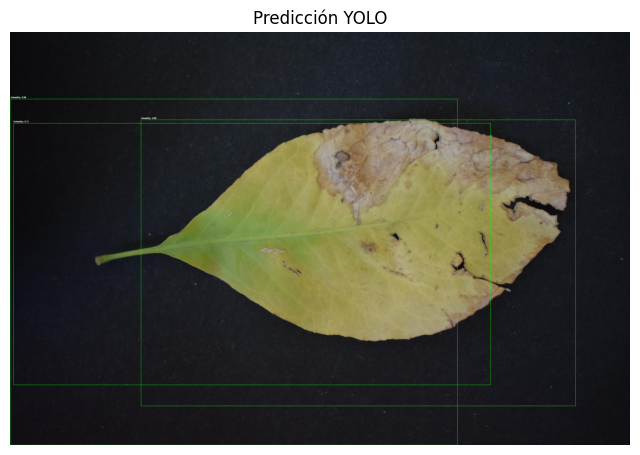

In [16]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# === Configuración ===
modelo_path = "/home/higgsos/Escritorio/agentes/runs/detect/train2/weights/best.pt"  # ← tu modelo entrenado
imagen_path = "/home/higgsos/.cache/kagglehub/datasets/csafrit2/plant-leaves-for-image-classification/versions/2/Plants_2/test/Bael diseased (P4b)/0016_0007.JPG"                        # ← la imagen que quieras probar
confianza_minima = 0.5  # Puedes bajarlo si no detecta nada

# === Cargar modelo ===
model = YOLO(modelo_path)
model.model.names ={
    0: 'Unhealthy',
    1: 'Healthy'
}
# === Realizar inferencia
results = model(imagen_path, conf=confianza_minima)

# === Mostrar detecciones por consola
print("Detecciones:")
boxes = results[0].boxes
if boxes is not None and len(boxes) > 0:
    for box in boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        print(f"Clase: {model.names[cls]} | Confianza: {conf:.2f}")
else:
    print("No se detectaron objetos.")

# === Dibujar resultado con OpenCV y mostrar en Jupyter
img = cv2.imread(imagen_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # coordenadas
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    label = f"{model.names[cls]}: {conf:.2f}"
    
    # Dibuja rectángulo y etiqueta
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (255,255,255), 2)

# Mostrar con matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Predicción YOLO")
plt.show()




In [14]:
print(model.names)

{0: 'Unhealthy', 1: 'Healthy'}
